In this notebook, we

1. load and inspect the graph data for Karate Club
2. code a simple neural message passing scheme (using 3-hops neighborhood)
3. inspect the resulting $h^{(k=3)}$ embeddings
4. Train the GNN and get results
5. Predict the class labels of the test nodes and calculate various classificaiton metrics

The **simple neural message passing scheme** entails using node features $\mathbf{x}_v^{(k)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(k + 1)} = f^{(k + 1)}_{\theta} \left( \mathbf{x}_v^{(k)}, \left\{ \mathbf{x}_u^{(k)} : u \in \mathcal{N}(v) \right\} \right)
$$


References: 
- Karate Club data: https://en.wikipedia.org/wiki/Zachary%27s_karate_club
- `GCNConv`: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html
- Intro to GNN colab notebook https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=1-W5Kfhu5I-P

Important environment setup can be found in `notes.txt`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import collections
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, multilabel_confusion_matrix

In [2]:
import networkx as nx
import torch
from torch.nn.modules import Linear
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx


In [3]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=50, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Acc: {accuracy: .3f}', fontsize=16)

## Load and inspect graph data
There is a single graph with 34 nodes, each has 34 features. There are 4 classes, but for the purpose of training, it is presumed that only 4 nodes have available class labels.

In [4]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [5]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
# edge_index represents A (adjacency matrix) 
# but it uses Coordinate format to deal with the sparse matrix representation
data.edge_index.t()

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [7]:
# node features
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [8]:
# node labels
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [9]:
# counts of each class
collections.Counter(data.y.detach().numpy())

Counter({0: 13, 1: 12, 3: 5, 2: 4})

In [10]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

## Visualize graph

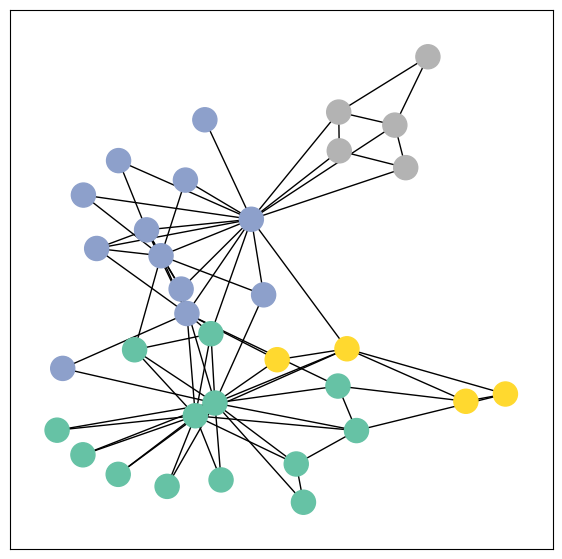

In [11]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Code the GCN model

We use the a simple GNN oprator, **GCN layer**, which is defined as

$$
\mathbf{h}_v^{(k + 1)} = \mathbf{W}^{(k + 1)} \sum_{u \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{u,v}} \cdot \mathbf{h}_u^{(k)}
$$

where $\mathbf{W}^{(k + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{u,v}$ refers to a fixed normalization coefficient for each edge (typically square root of the product of the node degrees of $u$ and $v$). $\mathbf{h}_u^{(k)}$ is the hidden embedding at k-hops from node $v$.

We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).

In addition, the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html) layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.


In [12]:
intermediate_hidden_size = 4
final_hidden_size = 2
num_features = dataset.num_features
num_classes = dataset.num_classes

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(in_channels=num_features, out_channels=intermediate_hidden_size)
        self.conv2 = GCNConv(in_channels=intermediate_hidden_size, out_channels=intermediate_hidden_size)
        self.conv3 = GCNConv(in_channels=intermediate_hidden_size, out_channels=final_hidden_size)
        self.classifier = Linear(in_features=final_hidden_size, out_features=num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        logits = self.classifier(h)
        return logits, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


## Visualize 2D model embeddings before training

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph. Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized completely at random and we have not yet performed any training so far! This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

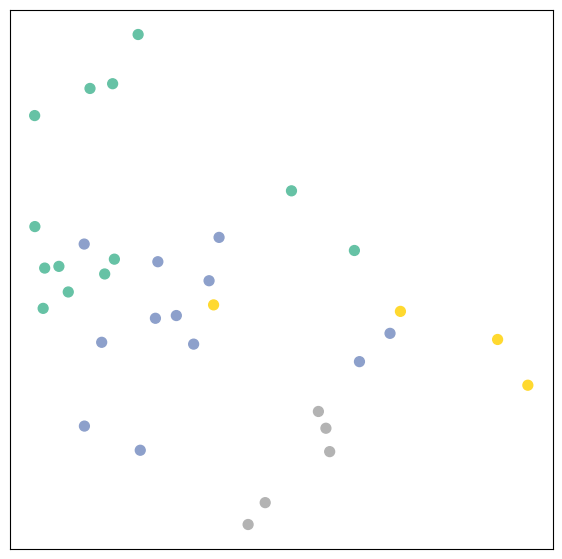

In [13]:
logits, h = model(data.x, data.edge_index)
visualize_embedding(h, color=data.y)

## Train GNN

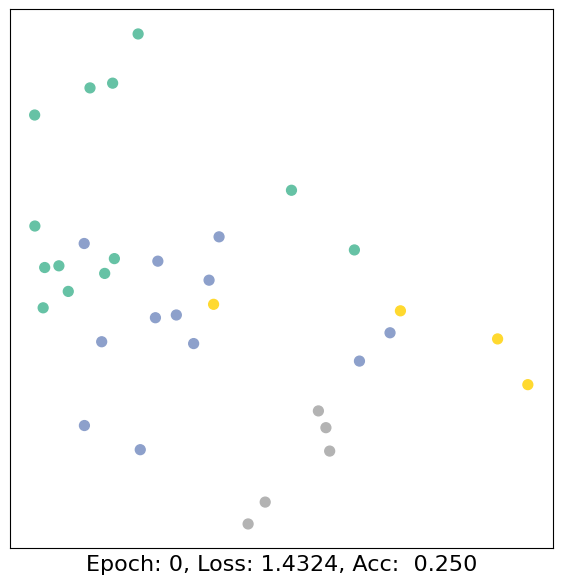

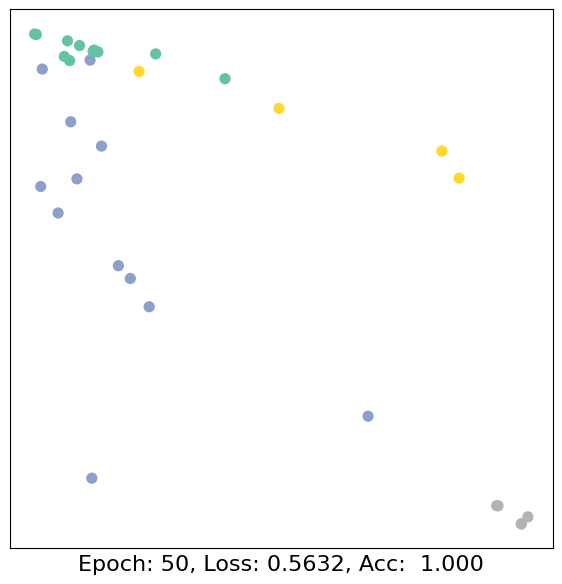

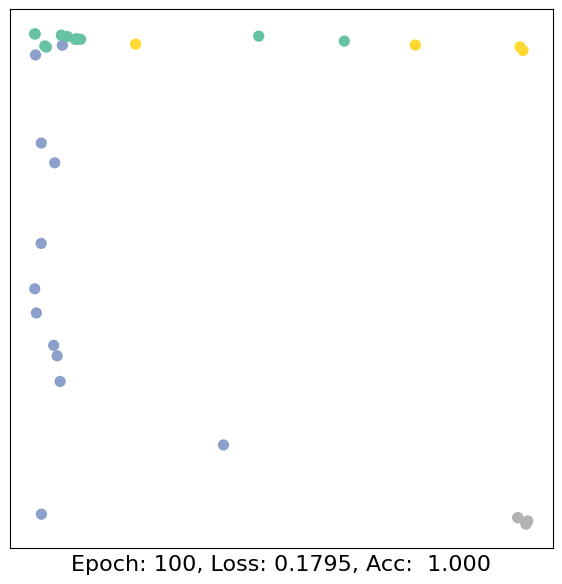

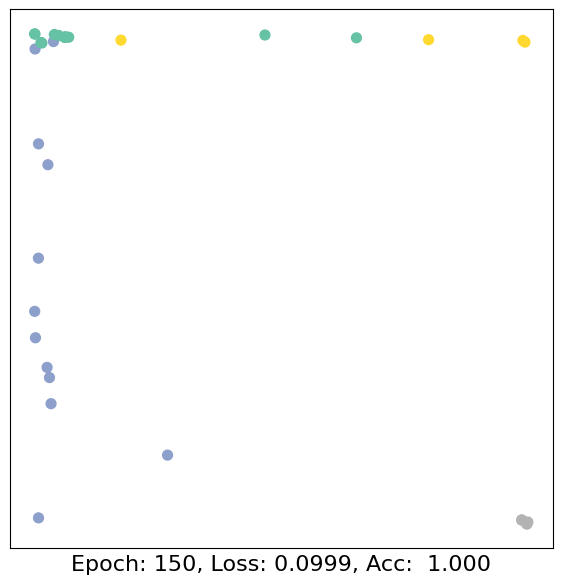

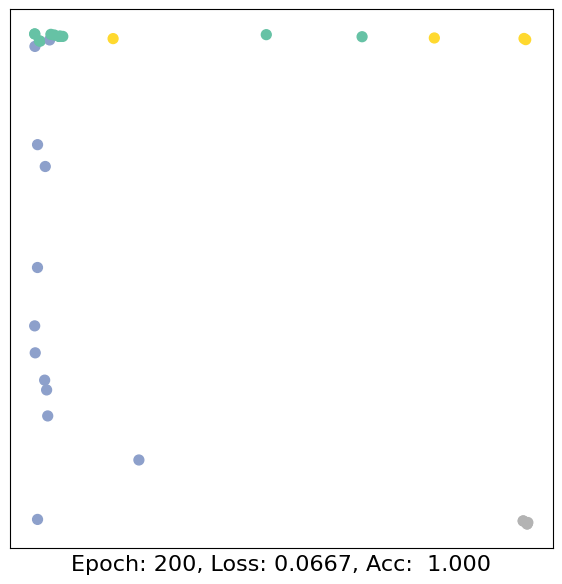

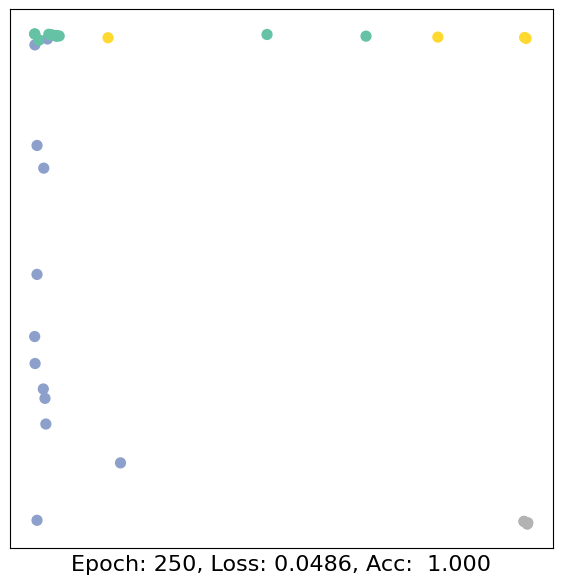

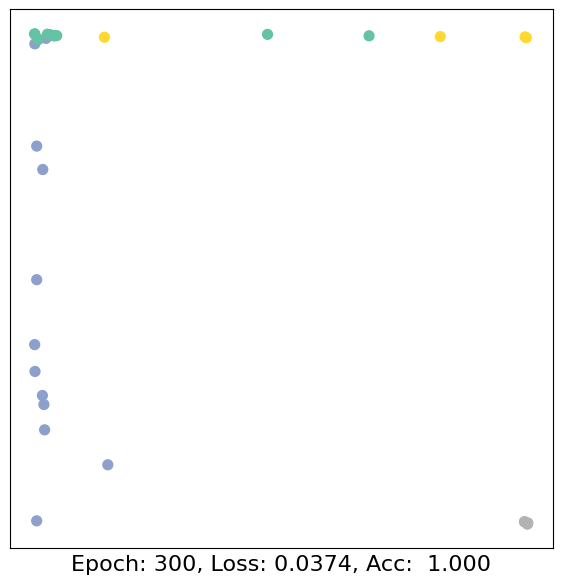

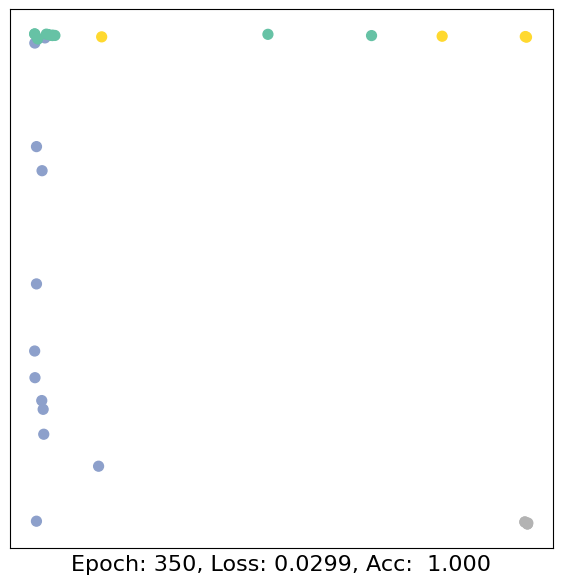

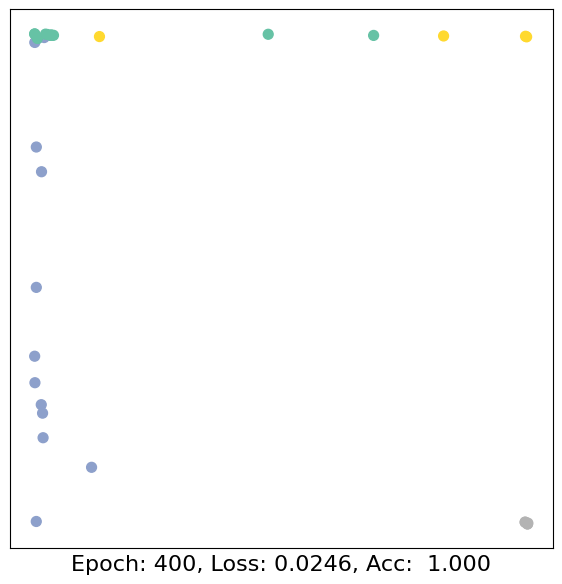

In [14]:
model = GCN()
# define loss criterion
criterion = torch.nn.CrossEntropyLoss()
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()  # clear gradients
    logits, h = model(data.x, data.edge_index)  # perform a single forward pass
    loss = criterion(logits[data.train_mask], 
                     data.y[data.train_mask])  # compute loss based on training set
    loss.backward()  # calculate gradients
    optimizer.step() # update model parameters based on gradients
    pred_train_labels = logits.argmax(dim=1)
    # accuracy_score(ytrue, ypred)
    accuracy = accuracy_score(data.y[data.train_mask], pred_train_labels[data.train_mask])
    return loss, h, accuracy


# Set the maximum number of open figures before matplotlib gives a warning
plt.rcParams['figure.max_open_warning'] = 50

for epoch in range(401):
    loss, h, accuracy = train(data)
    if epoch % 50 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.2)

## Predict on test set and obtain metrics
We obtain accuracy, precision, recall, and binary confusion matrices for each class. 

Scikit-Learn defineds the binary confusion matrix $C$ such that $C[i,j]$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus,
- $C[0, 0]$ is the count of true negatives 
- $C[1, 0]$ is the count of false negatives
- $C[0, 1]$ is the count of false positives is
- $C[1, 1]$ is the count of true positives

In our example, the elements of $C$ should sum to 30. And the true count of each class should be compared to the $C[1, 1]$ element.

In [15]:
def test(data):
    model.eval()
    with torch.no_grad():
        pred_logits, h = model(data.x, data.edge_index)
        pred_labels = pred_logits.argmax(dim=1)
    y_pred = pred_labels[~data.train_mask]
    y_true = data.y[~data.train_mask]
    # metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    # the labels order matches the order of collections.Counter(data.y.numpy())
    conf_matrix = multilabel_confusion_matrix(y_true, y_pred, labels=[0, 1, 3, 2])
    return(accuracy, precision, recall, conf_matrix)

accuracy, precision, recall, conf_matrix = test(data)

print(f"Accuracy: {accuracy}")
print(f"Precision:\n {precision}")
print(f"Recall:\n {recall}")

Accuracy: 0.8
Precision:
 [0.6875     1.         0.66666667 1.        ]
Recall:
 [0.91666667 0.63636364 0.66666667 1.        ]


In [16]:
conf_matrix

array([[[13,  5],
        [ 1, 11]],

       [[19,  0],
        [ 4,  7]],

       [[26,  0],
        [ 0,  4]],

       [[26,  1],
        [ 1,  2]]])

In [17]:
# true counts for each class, compare with C[1, 1] abovee 
collections.Counter(data.y[~data.train_mask].numpy())

Counter({0: 12, 1: 11, 3: 4, 2: 3})

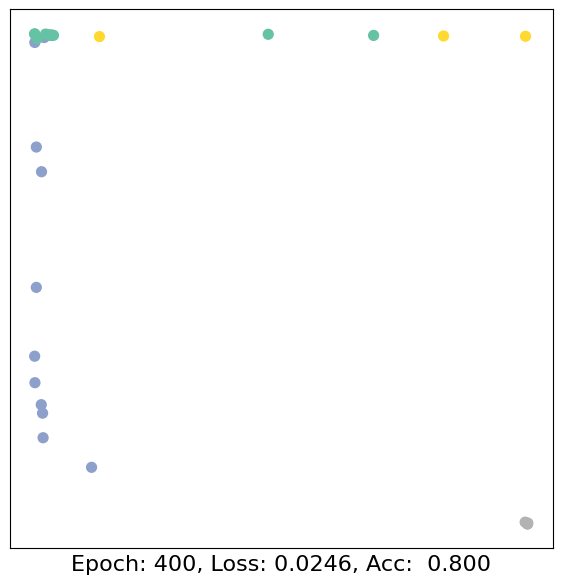

In [18]:
visualize_embedding(h[~data.train_mask], color=data.y[~data.train_mask], epoch=epoch, loss=loss)